In [23]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sps
from functools import reduce
from scipy.optimize import minimize
from pylab import *
import networkx as nx


from qiskit.circuit import Parameter
from qiskit.algorithms import *
from qiskit.circuit.library import *
from qiskit.opflow import *
from qiskit.algorithms.optimizers import *
from qiskit.utils import QuantumInstance


from qiskit import QuantumCircuit, transpile, assemble, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.ibmq import least_busy
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.test.mock import *

from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit.opflow import PauliExpectation, CircuitSampler, StateFn
from qiskit.opflow.gradients import *

-1.0 * ZZIIIIIIII
- 1.0 * IZZIIIIIII
- 1.0 * IIZZIIIIII
- 1.0 * IIIZZIIIII
- 1.0 * IIIIZZIIII
- 1.0 * IIIIIZZIII
- 1.0 * IIIIIIZZII
- 1.0 * IIIIIIIZZI
- 1.0 * IIIIIIIIZZ
- 1.0 * ZIIIIIIIIZ
- 1.0 * XIIIIIIIII
- 1.0 * IXIIIIIIII
- 1.0 * IIXIIIIIII
- 1.0 * IIIXIIIIII
- 1.0 * IIIIXIIIII
- 1.0 * IIIIIXIIII
- 1.0 * IIIIIIXIII
- 1.0 * IIIIIIIXII
- 1.0 * IIIIIIIIXI
- 1.0 * IIIIIIIIIX


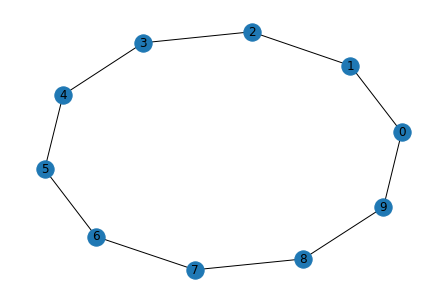

In [24]:
def termZZ(i,j,n):
    for pos in range(n):
        if pos==0:
            if(pos==i or pos==j):
                ter=Z
            else:
                ter=I
        else:        
            if(pos==i or pos==j):
                ter=ter^Z
            else:
                ter=ter^I
    return ter

def makeZZ(edges_list,coeff_list,n):
    Hnow=0
    for (edge,w) in zip(edges_list,coeff_list):
        i=edge[0]
        j=edge[1]
        Hnow = Hnow + w*(termZZ(i,j,n))
    return Hnow


def termX(i,n):
    te=1
    for pos in range(n):
        if pos==0:
            if(pos==i):
                te=X
            else:
                te=I
        else:        
            if(pos==i):
                te=te^X
            else:
                te=te^I
    return te

def makeX(n): # = sum_i X_i
    Hxnow=1.0*(termX(0,n))
    for i in range(1,n):
        Hxnow = Hxnow + 1.0*(termX(i,n))
    return Hxnow


nqubits=10 
edges=[]
for i in range(nqubits):
    edges.append((i,(i+1)%nqubits))

coeff=np.ones(len(edges))
Hzz = makeZZ(edges,coeff,nqubits)
Hx = makeX(nqubits)
Ht = -1.0*Hzz - 1.0*Hx # - 1.0*Hyy - 1.0*Hxx
print(Ht)    

#drawing
graphPl = nx.Graph(edges)
nx.draw(graphPl, with_labels=True)
plt.show()



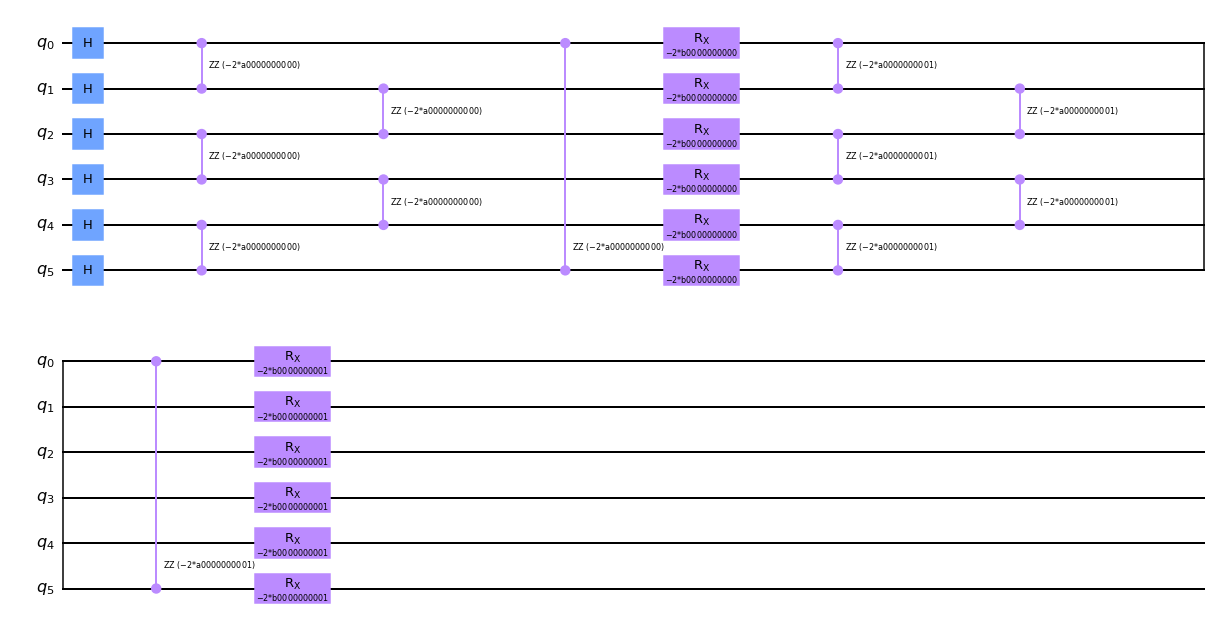

In [25]:
def makecirc(PP,dim): #QAOA circuit for the Ising model (Ring) 
    ci = QuantumCircuit(dim)
    for i in range(dim):
        ci.h(i)
    for p in range(PP):
        for i in range(dim//2):
            ci.rzz(-2*parGam[p],2*i,2*i+1)
        for i in range(dim//2):
            ci.rzz(-2*parGam[p],2*i+1,(2*i+2)%dim)
        if (dim%2==1):
            ci.rzz(-2*parGam[p],dim-1,0)
        for ii in range(dim):
            ci.rx(-2*parBet[p],ii)      

    return ci        


parGam=[]
parBet=[]

for i in range(P):
    parGam.append(Parameter(f'a{i:010b}'))
    parBet.append(Parameter(f'b{i:010b}'))

circ=makecirc(PP=2,dim=6) 
circ.draw("mpl")

In [26]:
def fidel(psifin,psi0):
    return np.linalg.norm(np.vdot(psifin,psi0))

def residual(now,emin,emax):
    return (now-emin)/(emax-emin)

In [29]:
fact=10**2

h=1 #transverse field
n=10 #nqubits
P=5 #QAOA circuit depth 

Ht=0
Ht=-1*termZZ(0,1,n)-h*termX(0,n) #using translational invariance we can consider only this Hamiltonian piece

edges=[]
for i in range(n):
    edges.append((i,(i+1)%n))
coeff=np.ones(len(edges))

HzzE = makeZZ(edges,coeff,n)
HxE = makeX(n)
Htt = -1*HzzE -h*HxE #I use this only for benchmarking

result = NumPyMinimumEigensolver().compute_minimum_eigenvalue(operator= 1*Htt)
emin=result.eigenvalue.real
psi0=result.eigenstate.to_matrix( massive= True)
print(emin)

result = NumPyMinimumEigensolver().compute_minimum_eigenvalue(operator= -1*Htt)
emax= -1*result.eigenvalue.real
print(emax)    

print(f"n={n}, P={P}")
parGam=[]
parBet=[]
for i in range(P):
    parGam.append(Parameter(f'a{i:010b}'))
    parBet.append(Parameter(f'b{i:010b}'))

circ=makecirc(P,n)
init=np.ones(2*P)/10

counts = []
values = []
stdval = []
def store_intermediate_result(eval_count, parameters, mean, std):
    values.append(residual((n)*mean,emin,emax))
    if(eval_count%100==0):
        print(repr(np.array(parameters)))
    print(str(eval_count)+": residual_en="+str(residual((n)*mean,emin,emax)))

qi=QuantumInstance(backend=Aer.get_backend('qasm_simulator'))
vqe = VQE(ansatz=circ, optimizer=L_BFGS_B(maxfun=100,factr=fact),max_evals_grouped=1000000, initial_point=init,callback=store_intermediate_result,quantum_instance=qi,include_custom=True)
result = vqe.compute_minimum_eigenvalue(operator=Ht)
print(result)

circ=makecirc(P,n) #generic circuit
qqq=circ.assign_parameters(result.optimal_point) #fixed parametrized circuit
psi=CircuitStateFn(qqq) 
fid=fidel(psi.to_matrix(massive= True),psi0) #fidelity. ( .to_matrix() gives you the numpy array)

en=n*result.optimal_value #translational invariance 
res_en=residual(n*result.optimal_value,emin,emax)
optparlist=result.optimal_point

print(f'Residual energy: {res_en}')
print(f'Fidelity: {fid}')

        

-12.784906442999352
12.784906442999302
n=10, P=5
1: residual_en=0.10120736107064335
2: residual_en=0.10120736107064335
3: residual_en=0.10120736367832092
4: residual_en=0.10120736610042975
5: residual_en=0.10120736711178636
6: residual_en=0.10120736653048236
7: residual_en=0.10120736476076596
8: residual_en=0.10120735819000685
9: residual_en=0.10120735641246621
10: residual_en=0.10120735621344881
11: residual_en=0.10120735747065042
12: residual_en=0.10120735954995266
13: residual_en=0.3451199195689271
14: residual_en=0.3451199195689271
15: residual_en=0.345119920579067
16: residual_en=0.34511991645971835
17: residual_en=0.3451199186361618
18: residual_en=0.3451199118151142
19: residual_en=0.3451199136623099
20: residual_en=0.34511991819421667
21: residual_en=0.3451199167576551
22: residual_en=0.3451199170386426
23: residual_en=0.34511991207532344
24: residual_en=0.3451199171854362
25: residual_en=0.11994564513488015
26: residual_en=0.11994564513488015
27: residual_en=0.1199456474115163

217: residual_en=0.011808839797255544
218: residual_en=0.011808839797255544
219: residual_en=0.01180883976807167
220: residual_en=0.011808839810867179
221: residual_en=0.011808839859831976
222: residual_en=0.011808839881791992
223: residual_en=0.011808839805706118
224: residual_en=0.011808839731157705
225: residual_en=0.011808839722155672
226: residual_en=0.011808839709287932
227: residual_en=0.011808839734351142
228: residual_en=0.011808839840940626
229: residual_en=0.01178919791363291
230: residual_en=0.01178919791363291
231: residual_en=0.01178919793597057
232: residual_en=0.011789197910246345
233: residual_en=0.01178919790995811
234: residual_en=0.011789197941152888
235: residual_en=0.011789197902649776
236: residual_en=0.011789197882947494
237: residual_en=0.01178919788747206
238: residual_en=0.011789197880420838
239: residual_en=0.011789197879114855
240: residual_en=0.011789197949761021
241: residual_en=0.011774780676370208
242: residual_en=0.011774780676370208
243: residual_en=0

447: residual_en=0.00737923737372138
448: residual_en=0.007379237381458279
449: residual_en=0.00737923737289947
450: residual_en=0.007379237325130474
451: residual_en=0.0073792374225013155
452: residual_en=0.007379237399248654
453: residual_en=0.007379237398714702
454: residual_en=0.007379237434309485
455: residual_en=0.007379237429094169
456: residual_en=0.007379237376194473
457: residual_en=0.007345727052101579
458: residual_en=0.007345727052101579
459: residual_en=0.007345727054826226
460: residual_en=0.007345726999855464
461: residual_en=0.007345727061691684
462: residual_en=0.007345727048582533
463: residual_en=0.007345727059105005
464: residual_en=0.007345727065345642
465: residual_en=0.0073457270653708604
466: residual_en=0.007345727038057003
467: residual_en=0.007345727054077608
468: residual_en=0.007345727072105157
469: residual_en=0.007337733305928328
470: residual_en=0.007337733305928328
471: residual_en=0.007337733311272582
472: residual_en=0.007337733279078675
473: residua

662: residual_en=0.006328033193443845
663: residual_en=0.006328032784086467
664: residual_en=0.006328033273421476
665: residual_en=0.0063280330652599
666: residual_en=0.006328033450087257
667: residual_en=0.006328033302480788
668: residual_en=0.006328033203771105
669: residual_en=0.00632803327136625
670: residual_en=0.006328033059120274
671: residual_en=0.006328033128216545
672: residual_en=0.006328033206983994
673: residual_en=0.007489492484907038
674: residual_en=0.007489492484907038
675: residual_en=0.007489492507844857
676: residual_en=0.007489492305803455
677: residual_en=0.007489492655429442
678: residual_en=0.007489492781217754
679: residual_en=0.007489492693073824
680: residual_en=0.007489493210312289
681: residual_en=0.007489492145412403
682: residual_en=0.00748949264162593
683: residual_en=0.007489492166221218
684: residual_en=0.007489492458944111
685: residual_en=0.006099230591661639
686: residual_en=0.006099230591661639
687: residual_en=0.006099230274986722
688: residual_en

879: residual_en=0.010517088715755971
880: residual_en=0.010517088273798212
881: residual_en=0.010517090290822952
882: residual_en=0.01051708696062129
883: residual_en=0.01051708967197787
884: residual_en=0.01051708748776213
885: residual_en=0.010517090801168657
886: residual_en=0.010517089110106601
887: residual_en=0.010517087731476114
888: residual_en=0.010517088572858237
889: residual_en=0.002614062351084346
890: residual_en=0.002614062351084346
891: residual_en=0.0026140626824057342
892: residual_en=0.002614062045665445
893: residual_en=0.0026140623069968887
894: residual_en=0.0026140617660035587
895: residual_en=0.0026140629303254125
896: residual_en=0.0026140620502359325
897: residual_en=0.002614062757375072
898: residual_en=0.0026140622404622863
899: residual_en=0.0026140623915411167
array([0.21709587, 0.42089877, 0.48313005, 0.49804658, 0.44601823,
       0.6844953 , 0.65256966, 0.61707514, 0.5740549 , 0.28171503])
900: residual_en=0.0026140621592126443
901: residual_en=0.00269

1107: residual_en=2.246145674155709e-11
1108: residual_en=2.2357597808887403e-11
1109: residual_en=2.249264915678698e-11
1110: residual_en=2.2336339726347655e-11
1111: residual_en=2.2422275177660298e-11
1112: residual_en=2.243929553786369e-11
1113: residual_en=2.2448743574548023e-11
1114: residual_en=2.2450132991707482e-11
1115: residual_en=2.2401781274558253e-11
1116: residual_en=2.246791753134858e-11
1117: residual_en=3.0380995608766943e-12
1118: residual_en=3.0380995608766943e-12
1119: residual_en=3.0508127278857593e-12
1120: residual_en=3.0281652281865506e-12
1121: residual_en=3.0349039014099348e-12
1122: residual_en=3.0443519380942674e-12
1123: residual_en=3.0563703965236023e-12
1124: residual_en=3.07304340243713e-12
1125: residual_en=3.018439308070326e-12
1126: residual_en=3.0406005117637237e-12
1127: residual_en=3.0235801515603304e-12
1128: residual_en=3.0527579119090045e-12
{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 94,
    'eigenstate': {   '0000000000': 

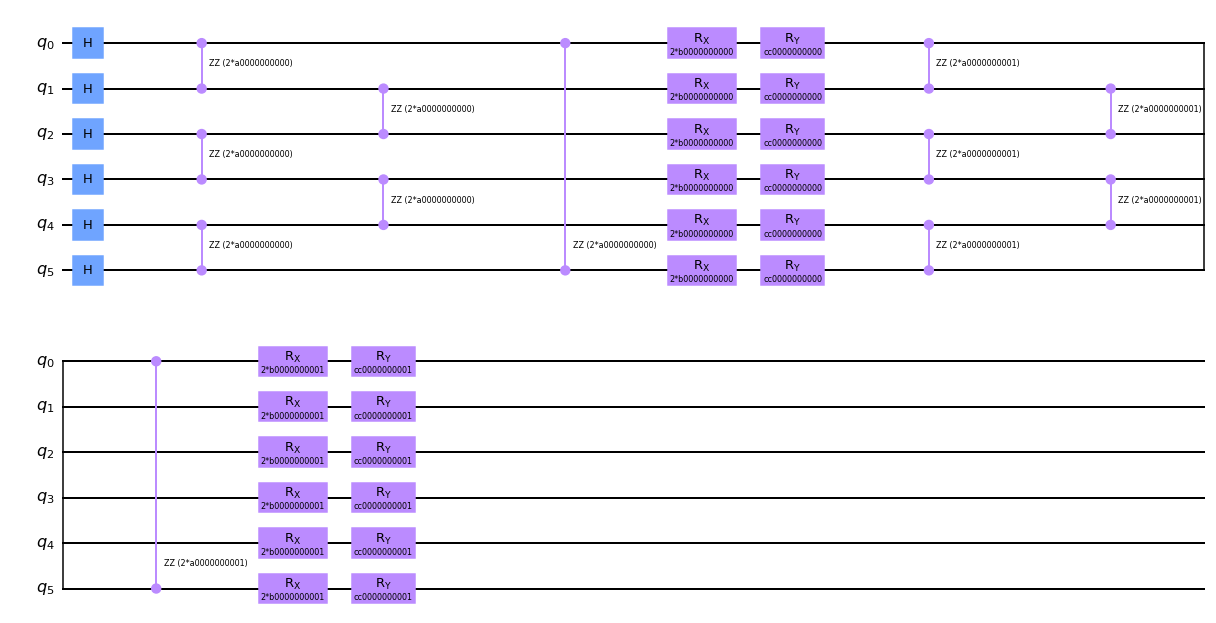

In [33]:
def makecirc_NotSym(PP,dim):
    ci = QuantumCircuit(dim)
    for i in range(dim):
        ci.h(i)
    for p in range(PP):
        for i in range(dim//2):
            ci.rzz(2*parGam[p],2*i,2*i+1)
        for i in range(dim//2):
            ci.rzz(2*parGam[p],2*i+1,(2*i+2)%dim)
        if (dim%2==1):
            ci.rzz(2*parGam[p],dim-1,0)
        #circ.barrier()
        for ii in range(dim):
            ci.rx(2*parBet[p],ii)      
        for i in range(dim):
            ci.ry(parNewP[p],i) 
    return ci        


P=2  
ndim=6

parGam=[]
parBet=[]
parNewP=[]

for i in range(P):
    parGam.append(Parameter(f'a{i:010b}'))
    parBet.append(Parameter(f'b{i:010b}'))
    parNewP.append(Parameter(f'cc{i:010b}'))


circ_NotSym=makecirc_NotSym(P,ndim) 
circ_NotSym.draw("mpl")


In [36]:
n=10
P=5
print(f"n={n}, P={P}")
parGam=[]
parBet=[]
parNewP=[]
for i in range(P):
    parGam.append(Parameter(f'a{i:010b}'))
    parBet.append(Parameter(f'b{i:010b}'))
    parNewP.append(Parameter(f'cc{i:010b}'))

circ_NotSym=makecirc_NotSym(P,n)
init=np.ones(3*P)/10

counts = []
values_NotSym = []
stdval = []
def store_intermediate_result(eval_count, parameters, mean, std):
    values_NotSym.append(residual((n)*mean,emin,emax))
    if(eval_count%100==0):
        print(repr(np.array(parameters)))
    print(str(eval_count)+": residual_en="+str(residual((n)*mean,emin,emax)))

qi=QuantumInstance(backend=Aer.get_backend('qasm_simulator'))
vqe = VQE(ansatz=circ_NotSym, optimizer=L_BFGS_B(maxfun=100,factr=fact),max_evals_grouped=1000000, initial_point=init,callback=store_intermediate_result,quantum_instance=qi,include_custom=True)
result = vqe.compute_minimum_eigenvalue(operator=Ht)
print(result)

circ_NotSym=makecirc_NotSym(P,n) #generic circuit
qqq=circ_NotSym.assign_parameters(result.optimal_point) #fixed parametrized circuit
psi=CircuitStateFn(qqq) 
fid_NotSym=fidel(psi.to_matrix(massive= True),psi0) #fidelity. ( .to_matrix() gives you the numpy array)

en_NotSym=n*result.optimal_value #translational invariance 
res_en_NotSym=residual(n*result.optimal_value,emin,emax)
optparlist_NotSym=result.optimal_point

print(f'Residual energy: {res_en_NotSym}')
print(f'Fidelity: {fid_NotSym}')

        

n=10, P=5
1: residual_en=0.1156501208354688
2: residual_en=0.1156501208354688
3: residual_en=0.11565012463873234
4: residual_en=0.11565012740687183
5: residual_en=0.11565012821245514
6: residual_en=0.11565012698455904
7: residual_en=0.11565012448283349
8: residual_en=0.11565011787483279
9: residual_en=0.11565011595426855
10: residual_en=0.11565011584237649
11: residual_en=0.11565011736298984
12: residual_en=0.11565011975885926
13: residual_en=0.11565012099423
14: residual_en=0.11565012103948512
15: residual_en=0.11565012137857189
16: residual_en=0.11565012181915447
17: residual_en=0.1156501220864652
18: residual_en=0.40397972863463966
19: residual_en=0.40397972863463966
20: residual_en=0.4039797280283197
21: residual_en=0.403979724438771
22: residual_en=0.40397972772068413
23: residual_en=0.40397972145947175
24: residual_en=0.4039797250598604
25: residual_en=0.4039797260809217
26: residual_en=0.40397972592466463
27: residual_en=0.4039797255825839
28: residual_en=0.4039797226904862
29: 

224: residual_en=0.006507414418649593
225: residual_en=0.006507414196120471
226: residual_en=0.006507414216591379
227: residual_en=0.006507414394431079
228: residual_en=0.006507414473376928
229: residual_en=0.006507414850768055
230: residual_en=0.006507414970256472
231: residual_en=0.0065074151049035
232: residual_en=0.006507415069852881
233: residual_en=0.0065074149894555075
234: residual_en=0.006507415042864287
235: residual_en=0.006507414863735416
236: residual_en=0.00650741471999375
237: residual_en=0.006507414712528342
238: residual_en=0.006507414760884506
239: residual_en=0.005748545623999923
240: residual_en=0.005748545623999923
241: residual_en=0.005748545114018244
242: residual_en=0.005748545495851338
243: residual_en=0.005748545857263056
244: residual_en=0.0057485458283750585
245: residual_en=0.005748545577157529
246: residual_en=0.00574854548229938
247: residual_en=0.005748545487622237
248: residual_en=0.00574854551173314
249: residual_en=0.005748545571303429
250: residual_e

428: residual_en=0.0036367040442280233
429: residual_en=0.0036367040906892297
430: residual_en=0.003636704250140341
431: residual_en=0.0036367042234722847
432: residual_en=0.003636704183804147
433: residual_en=0.0036367041127544943
434: residual_en=0.00363670409782611
435: residual_en=0.0036367040812377892
436: residual_en=0.0036367040511414853
437: residual_en=0.003636704066459601
438: residual_en=0.0036367040782078175
439: residual_en=0.003636704079470103
440: residual_en=0.003636704086022108
441: residual_en=0.0036367041088955273
442: residual_en=0.0036367041211832546
443: residual_en=0.0036136998886185587
444: residual_en=0.0036136998886185587
445: residual_en=0.0036136998857838006
446: residual_en=0.00361369990308517
447: residual_en=0.003613699996889794
448: residual_en=0.0036136999493829817
449: residual_en=0.0036136999149644785
450: residual_en=0.0036136999044248464
451: residual_en=0.0036136998933261125
452: residual_en=0.003613699888130804
453: residual_en=0.00361369987465123

630: residual_en=0.003244936154671734
631: residual_en=0.003244936154671734
632: residual_en=0.003244936147880124
633: residual_en=0.0032449361880706826
634: residual_en=0.003244936201918031
635: residual_en=0.0032449361871312974
636: residual_en=0.0032449361615566434
637: residual_en=0.00324493613667378
638: residual_en=0.0032449361314688145
639: residual_en=0.0032449361276465282
640: residual_en=0.00324493613256833
641: residual_en=0.003244936162637332
642: residual_en=0.003244936154537099
643: residual_en=0.0032449361611624657
644: residual_en=0.0032449361621860492
645: residual_en=0.0032449361695692036
646: residual_en=0.00324493617010663
647: residual_en=0.0032374919820085325
648: residual_en=0.0032374919820085325
649: residual_en=0.00323749199250419
650: residual_en=0.0032374919891272115
651: residual_en=0.003237491980221673
652: residual_en=0.0032374919797189816
653: residual_en=0.0032374919731769803
654: residual_en=0.003237491977206915
655: residual_en=0.0032374919789307653
65

853: residual_en=0.0032065605446698875
854: residual_en=0.0032065605343022654
855: residual_en=0.0032065605272195725
856: residual_en=0.00320656051361829
857: residual_en=0.003206560521747075
858: residual_en=0.0032065605568835595
859: residual_en=0.003206560556163702
860: residual_en=0.0032065605709092394
861: residual_en=0.0032065605704777555
862: residual_en=0.003206560563330663
863: residual_en=0.003206560557598206
864: residual_en=0.0032065605516172512
865: residual_en=0.003206560541907935
866: residual_en=0.0032065605430681675
867: residual_en=0.0032065605403864537
868: residual_en=0.0031990191117478306
869: residual_en=0.0031990191117478306
870: residual_en=0.0031990191237887973
871: residual_en=0.0031990190984979316
872: residual_en=0.0031990190814293585
873: residual_en=0.0031990190763823007
874: residual_en=0.003199019094324817
875: residual_en=0.0031990191166483047
876: residual_en=0.003199019120673724
877: residual_en=0.0031990191282812693
878: residual_en=0.003199019123518

1057: residual_en=0.0031897525333503722
1058: residual_en=0.00318975248122604
1059: residual_en=0.003189752339640263
1060: residual_en=0.0031897523107355234
1061: residual_en=0.0031897523256443168
1062: residual_en=0.003189752414353184
1063: residual_en=0.003189752442008699
1064: residual_en=0.003189752431685329
1065: residual_en=0.003189752479671352
1066: residual_en=0.0031897524450580526
1067: residual_en=0.0031897524438085495
1068: residual_en=0.0031897524322060133
1069: residual_en=0.0031897524244645283
1070: residual_en=0.0031897524087780085
1071: residual_en=0.0031897523863626803
1072: residual_en=0.003180698164534105
1073: residual_en=0.003180698164534105
1074: residual_en=0.003180698210826011
1075: residual_en=0.003180698182409929
1076: residual_en=0.0031806981322771185
1077: residual_en=0.0031806981207297418
1078: residual_en=0.0031806981354112265
1079: residual_en=0.0031806981640121706
1080: residual_en=0.0031806981743825718
1081: residual_en=0.0031806981748989487
1082: resid

1278: residual_en=0.0030999224446558423
1279: residual_en=0.0030999224860750628
1280: residual_en=0.003099922555677568
1281: residual_en=0.0030999225499815826
1282: residual_en=0.003099922529783556
1283: residual_en=0.003099922505937823
1284: residual_en=0.0030999224944169147
1285: residual_en=0.0030999225017094793
1286: residual_en=0.0030999224712300434
1287: residual_en=0.003099922525733405
1288: residual_en=0.003099922488798737
1289: residual_en=0.0030999224891672104
1290: residual_en=0.00309992249005088
1291: residual_en=0.003099922500250383
1292: residual_en=0.003099922508969253
1293: residual_en=0.0038506357822252093
1294: residual_en=0.0038506357822252093
1295: residual_en=0.003850635492398
1296: residual_en=0.0038506365000643195
1297: residual_en=0.00385063579339522
1298: residual_en=0.0038506358085529276
1299: residual_en=0.0038506350955314823
array([ 0.05510564,  0.04385387, -0.02808983,  0.21564605,  0.25624021,
        0.44043807,  0.39111728, -0.08301729,  0.4075415 ,  0.1

1499: residual_en=0.0029621350383643823
array([ 0.08238362,  0.03274312, -0.00432219,  0.24431462,  0.26590943,
        0.42930832,  0.39237762, -0.06830338,  0.43556239,  0.15510545,
        0.08726792,  0.13072299,  0.40508352,  0.12722506,  0.0121139 ])
1500: residual_en=0.0029621351881516803
1501: residual_en=0.0029621351336099706
1502: residual_en=0.0029621351318784095
1503: residual_en=0.002962134981524021
1504: residual_en=0.002962135056751721
1505: residual_en=0.0029621350455453764
1506: residual_en=0.0029621350389650272
1507: residual_en=0.002962135137890904
1508: residual_en=0.0029621351032682263
1509: residual_en=0.002962135091823944
1510: residual_en=0.0029621351121394465
1511: residual_en=0.002962135109379786
1512: residual_en=0.0029621351076514206
1513: residual_en=0.002962135046783347
1514: residual_en=0.0029551401994861483
1515: residual_en=0.0029551401994861483
1516: residual_en=0.002955140182873999
1517: residual_en=0.002955140256643922
1518: residual_en=0.00295514021

1703: residual_en=0.002768681640731852
1704: residual_en=0.002768681706574664
1705: residual_en=0.0027686817811087665
1706: residual_en=0.002768681759402597
1707: residual_en=0.0027686816790887967
1708: residual_en=0.002768681698154032
1709: residual_en=0.00276868167847266
1710: residual_en=0.0027686816732781848
1711: residual_en=0.0027686816652074775
1712: residual_en=0.0027686817134410244
1713: residual_en=0.002768681690045393
1714: residual_en=0.0027686817134994495
1715: residual_en=0.0027686817102359866
1716: residual_en=0.0027686817148505883
1717: residual_en=0.0027686817028763134
{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 101,
    'eigenstate': {   '0000000000': 0.03125,
                      '0000011100': 0.03125,
                      '0000011110': 0.03125,
                      '0000101110': 0.03125,
                      '0000111100': 0.03125,
                      '0000111110': 0.03125,
                      '0000111111': 0.05412658773652741,
          

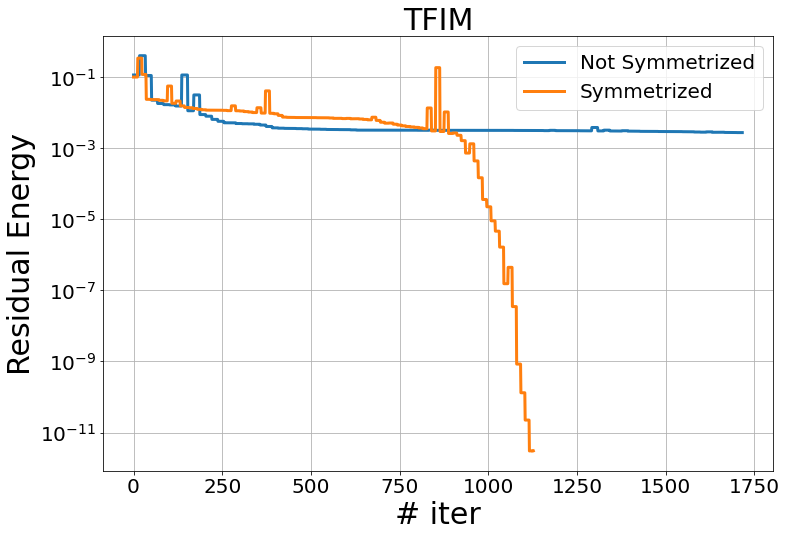

In [38]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
plt.yscale("log")
plt.plot(np.array(values_NotSym),linewidth=3,label=f"Not Symmetrized")
plt.plot(np.array(values),linewidth=3,label=f"Symmetrized")
plt.title(f'TFIM',size=30)

plt.grid()
plt.legend(fontsize=20)#,ncol=2,loc='upper right',borderpad=0.15,labelspacing=0.45,columnspacing=0.04,borderaxespad=0.05)#,bbox_to_anchor = (0., 0))

plt.xlabel("# iter",size=30)
plt.ylabel(r'Residual Energy',size=30)
plt.yticks(size=20)
plt.xticks(size=20)
plt.savefig(f'CompareSymNotSym2.pdf')
plt.show()   